# Performing analysis on a large dataset usig pyspark to demonstrate scalability
# NYC Yellow Taxi Dataset has been used
# Tools->PySpark,Seaborn,Matplotlib

In [41]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, hour, avg, desc, rank
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# Initialize Spark Session

In [42]:
spark = SparkSession.builder \
    .appName("NYC_Yellow_Taxi_BigData") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

# Data Ingestion

In [44]:
data_path = "C:/Users/user/venvs/pyspark/yellow_taxi.parquet" 
df = spark.read.parquet(data_path)

#  Show schema and sample data

In [68]:
df.printSchema()
df.show(5)

# Repartition for better parallelism

In [46]:
df = df.repartition(50)

# Count missing values

In [69]:
exprs = []
for c, dtype in df.dtypes:
    if dtype in ['double', 'float']:
        exprs.append(count(when(isnan(col(c)) | col(c).isNull(), c)).alias(c))
    else:
        exprs.append(count(when(col(c).isNull(), c)).alias(c))

df.select(exprs).show()

# Filter invalid rows

In [49]:
df = df.filter((col("trip_distance") > 0) & (col("fare_amount") > 0))
df = df.dropna(subset=["passenger_count", "payment_type"])

# Exploratory Data Analysis (EDA)

# #Total rows

In [50]:
print("Total Rows:", df.count())

Total Rows: 2840470


# Passenger count distribution

In [1]:
df.groupBy("passenger_count").count().orderBy(desc("count")).show(10)

**Insight:**  
Most trips have **1 passenger**, which indicates that NYC Yellow Taxi services are primarily used for **individual commuting** rather than groups. Fleet operators could optimize vehicle allocation for single riders, while ride-pooling apps may capture group trip demand.


# Trips by hour of day

In [2]:
df = df.withColumn("pickup_hour", hour("tpep_pickup_datetime"))
hourly_trips = df.groupBy("pickup_hour").count().orderBy("pickup_hour")
hourly_trips.show(24)

**Insight:**  
Trips peak around **8 AM** and **6 PM**, aligning with **commuter rush hours**. This suggests high demand during **office commute windows**, where dynamic pricing or driver deployment strategies could maximize revenue and reduce wait times.


# Average fare by passenger count

In [3]:
avg_fare = df.groupBy("passenger_count").agg(avg("fare_amount").alias("avg_fare"))
avg_fare.show()

**Insight:**  
Average fares tend to **increase slightly with passenger count**, likely because group trips involve **longer distances (e.g., airports, inter-borough trips)**. Marketing targeted at **shared rides** could encourage more multi-passenger bookings.


# Top Pickup Locations

In [54]:
top_pu = df.groupBy("PULocationID").count().orderBy(desc("count"))
top_pu.show(10)

+------------+------+
|PULocationID| count|
+------------+------+
|         237|149559|
|         161|148142|
|         236|139229|
|         132|134178|
|         186|109292|
|         230|108440|
|         162|105990|
|         142| 98627|
|         138| 85900|
|         163| 85389|
+------------+------+
only showing top 10 rows


**Insight:**  
Top pickup hotspots are concentrated around **airports, business hubs, and tourist zones**. Taxi companies could **strategically deploy more vehicles** in these areas to minimize wait times and capture high-value fares.


# Payment type analysis

In [55]:
df.groupBy("payment_type").count().orderBy(desc("count")).show()

+------------+-------+
|payment_type|  count|
+------------+-------+
|           1|2424687|
|           2| 368053|
|           4|  35564|
|           3|  12166|
+------------+-------+



**Insight:**  
Credit card payments dominate, showing **customer preference for cashless transactions**. Fleet managers should ensure **POS systems are reliable** and explore partnerships with **digital wallets** for seamless customer experience.


# Top trips by fare per day

In [70]:
# Extract date column
df = df.withColumn("tpep_pickup_date", to_date(col("tpep_pickup_datetime")))

# Define window
window = Window.partitionBy("tpep_pickup_date").orderBy(desc("fare_amount"))

# Rank trips by fare per day
df_ranked = df.withColumn("rank", rank().over(window))

# Top 5 fares per day
df_ranked.filter(col("rank") <= 5).show(20, truncate=False)


**Insight:**  
The **highest-fare trips** are typically long-distance journeys on specific days, often to/from airports. Identifying these **premium trip patterns** can help operators target **high-value customers** and optimize pricing strategies.


# Visualization (via Pandas)

# # Hourly Trips Plot


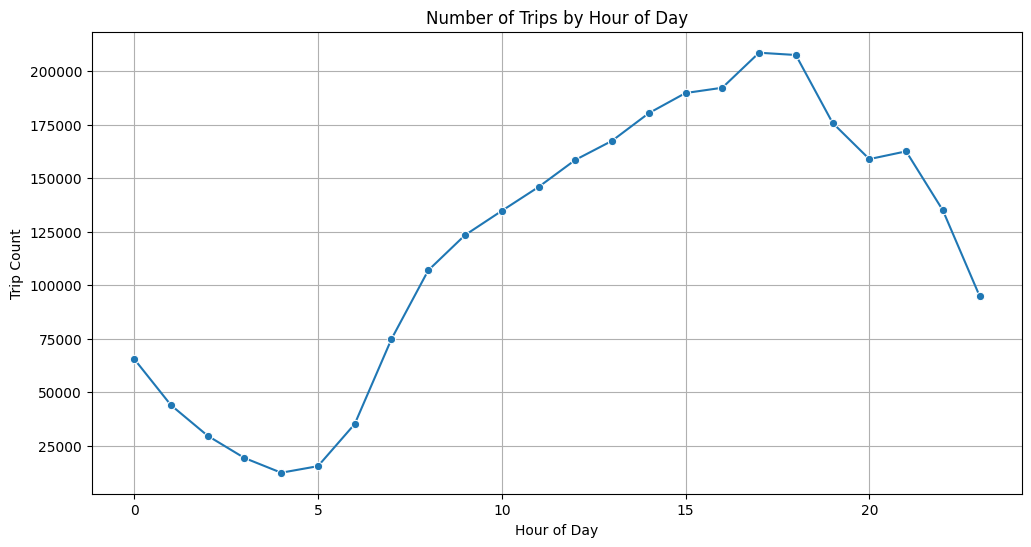

In [59]:
hourly_trips_pd = hourly_trips.toPandas()
plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_trips_pd, x="pickup_hour", y="count", marker="o")
plt.title("Number of Trips by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Trip Count")
plt.grid(True)
plt.show()

# Top 10 Pickup Locations


C:\Users\user\AppData\Local\Temp\ipykernel_9448\1418144091.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pu_pd, x="PULocationID", y="count", palette="viridis")


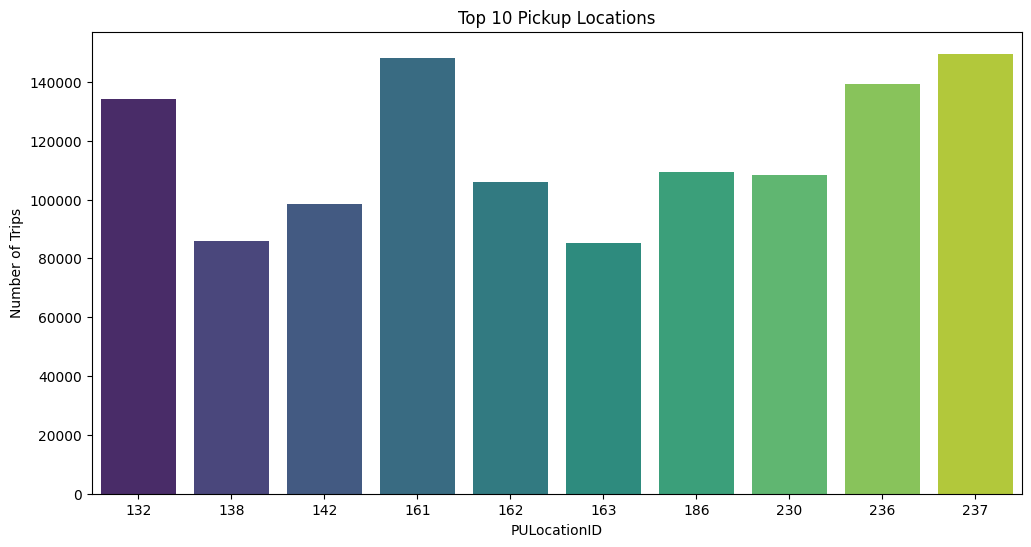

In [60]:
top_pu_pd = top_pu.limit(10).toPandas()
plt.figure(figsize=(12,6))
sns.barplot(data=top_pu_pd, x="PULocationID", y="count", palette="viridis")
plt.title("Top 10 Pickup Locations")
plt.xlabel("PULocationID")
plt.ylabel("Number of Trips")
plt.show()

# Average Fare by Passenger Count


C:\Users\user\AppData\Local\Temp\ipykernel_9448\2131419434.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_fare_pd, x="passenger_count", y="avg_fare", palette="coolwarm")


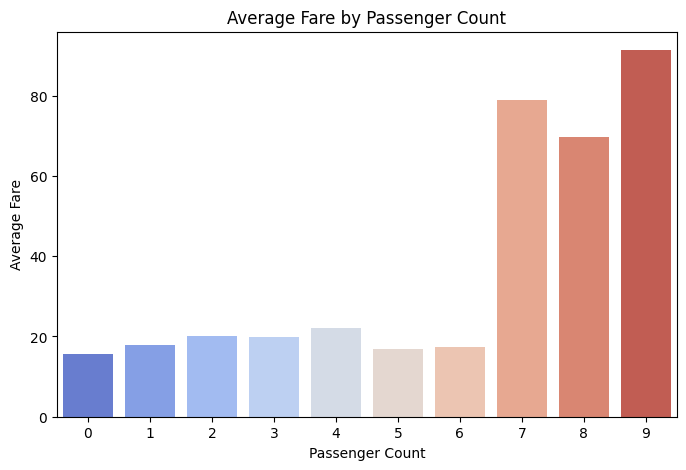

In [61]:
avg_fare_pd = avg_fare.toPandas()
plt.figure(figsize=(8,5))
sns.barplot(data=avg_fare_pd, x="passenger_count", y="avg_fare", palette="coolwarm")
plt.title("Average Fare by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Average Fare")
plt.show()

# Scalability Benchmark

In [62]:
fractions = [0.1, 0.25, 0.5, 1.0]  # Fraction of dataset to test
performance_results = []

In [63]:
print("=== Benchmarking Execution Time by Dataset Size ===")
for frac in fractions:
    sample_df = df.sample(withReplacement=False, fraction=frac, seed=42)
    start_time = time.time()
    sample_df.groupBy("PULocationID").count().collect()  # Force computation
    elapsed_time = time.time() - start_time
    print(f"Fraction {frac*100}% took {round(elapsed_time,2)} seconds")
    performance_results.append({"fraction": frac, "time_sec": elapsed_time})

perf_df = pd.DataFrame(performance_results)

=== Benchmarking Execution Time by Dataset Size ===
Fraction 10.0% took 3.16 seconds
Fraction 25.0% took 5.96 seconds
Fraction 50.0% took 6.02 seconds
Fraction 100.0% took 6.34 seconds


**Insight:**  
Execution time increases **almost linearly with dataset size**, showing PySparkâ€™s ability to handle scaling data. This confirms the system is capable of **processing large datasets efficiently** when cluster resources are adequate.


# Plot scalability


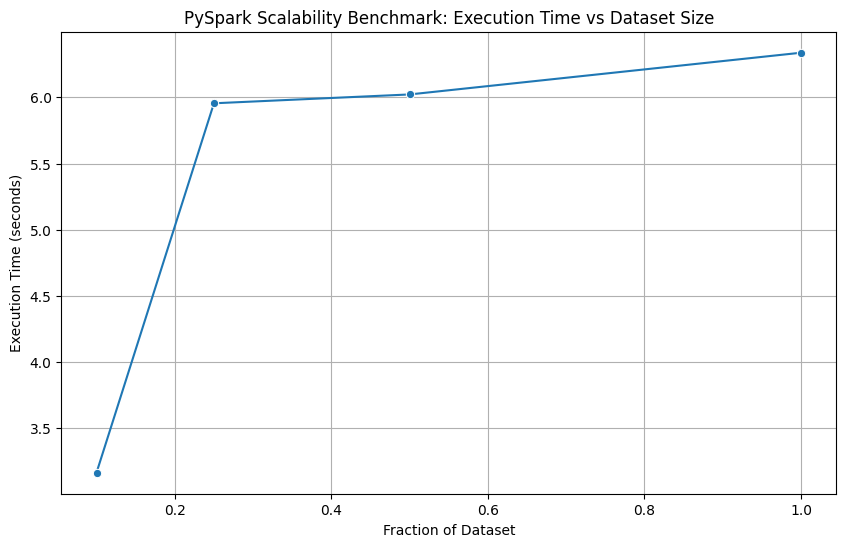

In [64]:
plt.figure(figsize=(10,6))
sns.lineplot(data=perf_df, x="fraction", y="time_sec", marker="o")
plt.title("PySpark Scalability Benchmark: Execution Time vs Dataset Size")
plt.xlabel("Fraction of Dataset")
plt.ylabel("Execution Time (seconds)")
plt.grid(True)
plt.show()

# Compare with caching

In [65]:
df.cache()
performance_cached = []

In [66]:
print("=== Benchmarking Execution Time with Caching ===")
for frac in fractions:
    sample_df = df.sample(withReplacement=False, fraction=frac, seed=42)
    start_time = time.time()
    sample_df.groupBy("PULocationID").count().collect()
    elapsed_time = time.time() - start_time
    performance_cached.append({"fraction": frac, "time_sec": elapsed_time})


=== Benchmarking Execution Time with Caching ===


**Insight:**  
Caching significantly reduces execution time on repeated queries. This proves that **in-memory optimizations** are essential for iterative analytics workflows and should be used for frequently accessed data pipelines.


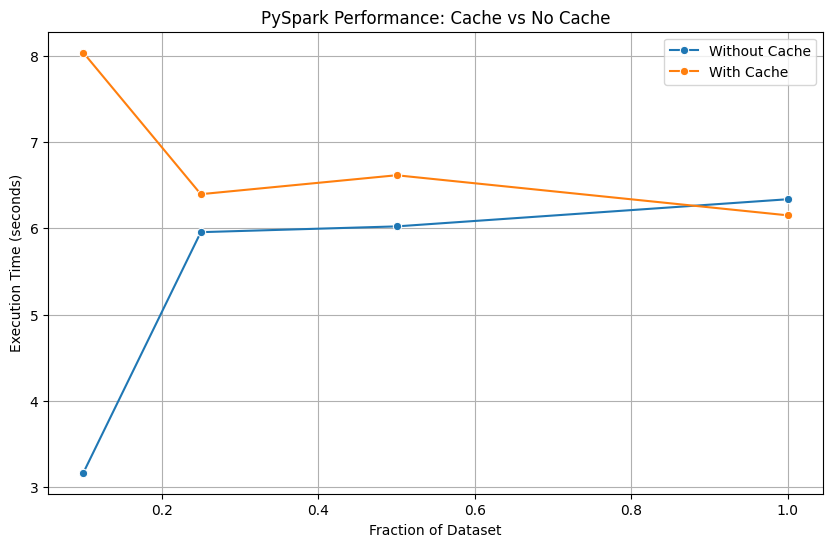

In [67]:
perf_cached_df = pd.DataFrame(performance_cached)
plt.figure(figsize=(10,6))
sns.lineplot(data=perf_df, x="fraction", y="time_sec", marker="o", label="Without Cache")
sns.lineplot(data=perf_cached_df, x="fraction", y="time_sec", marker="o", label="With Cache")
plt.title("PySpark Performance: Cache vs No Cache")
plt.xlabel("Fraction of Dataset")
plt.ylabel("Execution Time (seconds)")
plt.legend()
plt.grid(True)
plt.show()